In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import gdown
file_id = "13BJXv4_D-7eOGBLKZFjmNL0A-yFPKiHQ"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="RecipeNLG_dataset.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=13BJXv4_D-7eOGBLKZFjmNL0A-yFPKiHQ
From (redirected): https://drive.google.com/uc?id=13BJXv4_D-7eOGBLKZFjmNL0A-yFPKiHQ&confirm=t&uuid=b965f1a1-9842-4335-839c-15a202e90539
To: /content/RecipeNLG_dataset.csv
100%|██████████| 2.29G/2.29G [00:40<00:00, 56.7MB/s]


'RecipeNLG_dataset.csv'

In [6]:
import pandas as pd

df = pd.read_csv("RecipeNLG_dataset.csv")
df.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [7]:
import json

df["ingredients"] = df["ingredients"].apply(json.loads)
df["directions"] = df["directions"].apply(json.loads)

In [8]:
# Define common fridge items
fridge_items = {
    "milk", "cheese", "cream cheese", "butter", "yogurt", "sour cream", "egg",
    "tomato", "onion", "lettuce", "spinach", "cabbage", "zucchini", "carrot",
    "garlic", "cucumber", "pepper", "celery", "apple", "grapes", "corn", "mushroom"
}

# Fridge inventory filter
def has_fridge_item(ingredients):
    match_count = sum(item.lower() in fridge_items for item in ingredients)
    return 2 <= len(ingredients) <= 10 and match_count >= 1

# Apply filter
df_subset = df[df["ingredients"].apply(has_fridge_item)].sample(frac=0.1, random_state=42)

In [9]:
# Convert ingredients and directions back to string
df_subset["text"] = df_subset.apply(
    lambda x: f"{', '.join(x['ingredients'])} -> {x['title'].strip()}. Instructions: {' '.join(x['directions']).strip()}",
    axis=1
)
df_subset = df_subset.dropna(subset=["text"])

In [10]:
df_subset["text"].to_csv("filtered_recipes_gpt.txt", index=False, header=False)

In [11]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [12]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [13]:
from transformers import GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load training data
with open("filtered_recipes_gpt.txt", "r") as f:
    lines = [line.strip() for line in f if line.strip()]

class RecipeDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.examples = tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )

    def __len__(self):
        return self.examples["input_ids"].shape[0]

    def __getitem__(self, idx):
        return {
            "input_ids": self.examples["input_ids"][idx],
            "attention_mask": self.examples["attention_mask"][idx],
        }

dataset = RecipeDataset(lines, tokenizer)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [14]:
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()

epochs = 15
epoch_losses = []
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(loader):
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(loader)}")


100%|██████████| 1382/1382 [02:30<00:00,  9.17it/s]


Epoch 1 - Loss: 2.2691305573442047


100%|██████████| 1382/1382 [02:30<00:00,  9.18it/s]


Epoch 2 - Loss: 2.0065029161711334


100%|██████████| 1382/1382 [02:30<00:00,  9.21it/s]


Epoch 3 - Loss: 1.8575676669260182


100%|██████████| 1382/1382 [02:29<00:00,  9.24it/s]


Epoch 4 - Loss: 1.7322643143482042


100%|██████████| 1382/1382 [02:29<00:00,  9.23it/s]


Epoch 5 - Loss: 1.6170856253110553


100%|██████████| 1382/1382 [02:28<00:00,  9.30it/s]


Epoch 6 - Loss: 1.507068947496704


100%|██████████| 1382/1382 [02:28<00:00,  9.30it/s]


Epoch 7 - Loss: 1.404761269537654


100%|██████████| 1382/1382 [02:28<00:00,  9.30it/s]


Epoch 8 - Loss: 1.310657592158759


100%|██████████| 1382/1382 [02:28<00:00,  9.31it/s]


Epoch 9 - Loss: 1.2198252560821525


100%|██████████| 1382/1382 [02:28<00:00,  9.30it/s]


Epoch 10 - Loss: 1.132867633541655


100%|██████████| 1382/1382 [02:28<00:00,  9.30it/s]


Epoch 11 - Loss: 1.0538001764139804


100%|██████████| 1382/1382 [02:28<00:00,  9.31it/s]


Epoch 12 - Loss: 0.9768427115920311


100%|██████████| 1382/1382 [02:28<00:00,  9.32it/s]


Epoch 13 - Loss: 0.9067496295948277


100%|██████████| 1382/1382 [02:28<00:00,  9.32it/s]


Epoch 14 - Loss: 0.8412868664229313


100%|██████████| 1382/1382 [02:28<00:00,  9.31it/s]

Epoch 15 - Loss: 0.7792157942237798


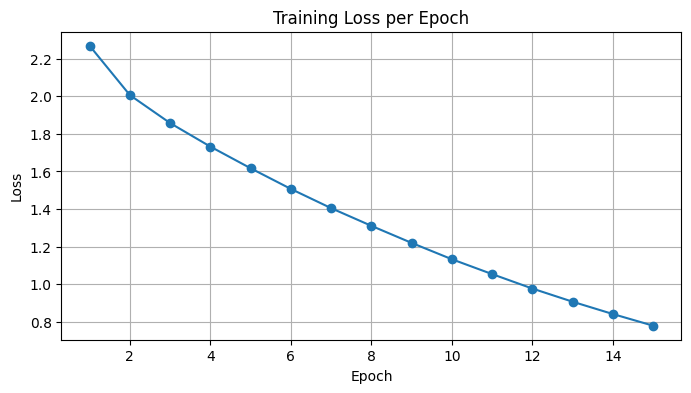

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [49]:
model.save_pretrained("gpt2-recipes-manual")
tokenizer.save_pretrained("gpt2-recipes-manual")
print("Model saved to 'gpt2-recipes-manual'")

Model saved to 'gpt2-recipes-manual'


**Model Testing**

In [50]:
model.eval()
prompt = (
    "Ingredients: egg, flour, sugar\n"
    "Recipe Title: "
)

inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Generate output
output = model.generate(
    **inputs,
    max_length=120,
    do_sample=True,
    top_k=50,
    top_p=0.92,
    temperature=0.65,
    repetition_penalty=1.3,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Prompt:", prompt)
print(generated_text[len(prompt):].strip())

Prompt: Ingredients: egg, flour, sugar
Recipe Title: 
Egg to Beat Recipe. Instructions: Mix beaten eggs with some milk or cream until it seems like a mix for you! You will need an oven bag."


In [59]:
model.eval()

prompt = "cheese, tomato, lettuce →"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

output = model.generate(
    **inputs,
    max_length=100,
    do_sample=True,
    top_k=50,
    top_p=0.9,
    temperature=0.6,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.eos_token_id
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Prompt:", prompt)
print(generated_text[len(prompt):].strip())

Prompt: cheese, tomato, lettuce →
Tomato Slaw. Instructions: Boil the onion until soft and clear; drain in colander. Fry sliced tomatoes till light brown on both sides with a little oil. Serve hot with melted butter or bacon grease."


In [60]:
model.eval()

prompt = "Ingredients: egg, flour, sugar → Recipe:"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

output = model.generate(
    **inputs,
    max_length=100,
    do_sample=True,
    top_k=50,
    top_p=0.9,
    temperature=0.6,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.eos_token_id
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Prompt:", prompt)
print(generated_text[len(prompt):].strip())

Prompt: Ingredients: egg, flour, sugar → Recipe:
Egg In A Basket. Instructions: Crack a hole in the center of an egg. Pour into empty egg vial (let stand for 5 minutes). Drop in large fryer which has a shallow rack and a shallow deep dish. Dip the two halves in egg and then dip again in egg. Repeat until all the liquid is absorbed by the hole removed."


In [43]:
model.eval()
prompt = "cheese, tomato, lettuce -> "


inputs = tokenizer(prompt, return_tensors="pt").to(device)

output = model.generate(
    **inputs,
    max_length=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.6,
    pad_token_id=tokenizer.eos_token_id
)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

cheese, tomato, lettuce ->  Fresh Vegetable Salad. Instructions: Shred cheese. Chop tomatoes. Slice lettuce. Put in bowl with cheese. Add salt and pepper to taste. Serve. Makes 18 to 20 servings."


In [61]:
from torch.nn import CrossEntropyLoss
import math
import torch

def calculate_perplexity(model, tokenizer, text):
    model.eval()

    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss

    return math.exp(loss.item())

prompt = "Ingredients: egg, flour, sugar → Recipe:"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
output = model.generate(
    **inputs,
    max_length=100,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Prompt:", prompt)
print(generated_text[len(prompt):].strip())

full_text = prompt + " " + generated_text[len(prompt):].strip()
perplexity = calculate_perplexity(model, tokenizer, full_text)
print(f"Perplexity: {perplexity:.2f}")

Prompt: Ingredients: egg, flour, sugar → Recipe:
Egg In A Dish. Instructions: Beat egg in a bowl. Add flour, sugar and salt. Mix well. Fry in hot oil until light brown."
Perplexity: 8.60


In [66]:
from torch.nn import CrossEntropyLoss
import math
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

model.eval()

prompt = "Ingredients: egg, flour, sugar → Recipe:"
reference = "Pancake. Instructions: Mix egg, flour, and sugar. Fry until golden."

inputs = tokenizer(prompt, return_tensors="pt").to(device)
output = model.generate(
    **inputs,
    max_length=100,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)
generated = tokenizer.decode(output[0], skip_special_tokens=True)
generated_cont = generated[len(prompt):].strip()

# BLEU score
smoothie = SmoothingFunction().method4
bleu = sentence_bleu([reference.split()], generated_cont.split(), smoothing_function=smoothie)

# Perplexity
def calculate_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        return math.exp(outputs.loss.item())

ppl = calculate_perplexity(prompt + " " + generated_cont)

print("Prompt:", prompt)
print(generated_cont)
print(f"BLEU: {bleu:.3f}")
print(f"Perplexity: {ppl:.2f}")

Prompt: Ingredients: egg, flour, sugar → Recipe:
Egg In A Dish. Instructions: Beat egg in a bowl. Add flour, sugar and salt. Mix well. Fry in hot oil until light brown."
BLEU: 0.018
Perplexity: 8.60
